In [2]:
%matplotlib inline

import tensorflow as tf
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os

### MNIST Dataset 가져오기

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist_data/")

train_images = mnist.train.images
valid_images = mnist.validation.images
test_images = mnist.test.images

W0628 22:15:25.105480 4583122368 deprecation.py:323] From <ipython-input-3-b005235c05c5>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0628 22:15:25.106379 4583122368 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0628 22:15:25.107334 4583122368 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be re

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist_data/train-images-idx3-ubyte.gz


W0628 22:15:27.164268 4583122368 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist_data/t10k-images-idx3-ubyte.gz


W0628 22:15:28.404367 4583122368 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### [Optional.  Tensorflow Graph Visualization ]

---

> _Jupyter에서 Tensorflow에서 구성되는 Graph를 시각적으로 보여주기 위한 helper 메소드입니다._<br>

In [4]:
from IPython.display import clear_output, Image, display, HTML
import numpy as np    

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))

    display(HTML(iframe))

<br><br>

# \[ Variational Auto Encoder \]

> *Auto Encoder는 입력을 Latent Vector로 변환하는 Encoder 부분과 Latent Vectord에서 입력으로 복원하는 Decoder 부분으로 나뉘어 집니다. Variational Auto Encoder가 목표로 하는 것은 "잘 만들어진" Latent Vector을 만드는 것이 목적입니다.

## 1. Variational AutoEncoder이란?
---

![Imgur](https://i.imgur.com/fWLS82f.jpg)

Variational Auto Encoder가 Auto Encoder와 다른 것은 바로 Latent Vector(z)을 확률 분포(Distribution)으로 만든다는 점에 있습니다. Auto Encoder와 다르게, Variational Auto Encoder에서의 Encoder는 해당 데이터에 대한 확률 분포의 **평균**과 **분산**을 찾습니다. 그리고 주어진 평균과 분산을 통해, 확률 분포에서 latent Vector을 뽑아서, Decoder에서 이미지를 복원하게 됩니다.


### (1) 인코더 구성하기


우리는 인코더에서 만들어낸 code의 평균과 표준편차에서, 하나의 Code를 랜덤하게 추출하게 됩니다.<br>
이렇게 랜덤하게 추출하게 되더라도, 아 잠재 공간 내 이미지들은 유사해야한다는 가정이 있어,<br>
Decoder는 원래 이미지로 복원하는 방향으로 학습되게 됩니다.

In [5]:
graph = tf.Graph()

num_input =784
num_hidden1 = 500
num_hidden2 = 500
num_hidden3 = 2

with graph.as_default():
    x = tf.placeholder(tf.float32, shape=(None,num_input),
                       name='x')
    lr = tf.placeholder_with_default(0.01, None, 
                                     name='learning_rate')
    encoded_1 = tf.layers.Dense(num_hidden1, 
                                activation=tf.nn.leaky_relu,
                                name='encode_1')(x)
    encoded_2 = tf.layers.Dense(num_hidden2,
                                activation=tf.nn.relu,
                                name='encode_2')(encoded_1)   
    
    with tf.variable_scope("reparameterization_trick"):
        # Encoder 중 확률분포의 평균을 찾는 Layer
        code_mean = tf.layers.Dense(num_hidden3,
                                   name='code_mean')(encoded_2)
        
        # Encoder 중 확률분포의 분산을 찾는 Layer
        code_sigma = tf.layers.Dense(num_hidden3,
                                   activation=tf.nn.softplus,
                                   name='code_gamma')(encoded_2)
        
        # reparameterization trick
        # 아래와 같이 확률분포에서 Sampling하게 되면서, 
        # code_mean과 code_sigma 쪽으로 역전파가 가능하게 됨
        noise = tf.random.normal(tf.shape(code_sigma))
        sampled_code = code_mean + code_sigma * noise
    sampled_code = tf.identity(sampled_code,"sampled_code")    

W0628 22:15:28.849903 4583122368 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


역전파가 된다는 의미는 아래의 그림을 통해 이해해 보면 됩니다. 그림 속에서 왼쪽과 Sampling할 경우 우리는 BackPropagation을 수행할 수 없지만, 오른쪽과 같이 Neural Network을 구성하게 되면서 역전파가 수행가능하게 됩니다.

![](http://1.bp.blogspot.com/-fOv-fxk6W0Y/WQ13qrHrulI/AAAAAAAABqw/dTXlXdQHIrAGjjz5Vm7X97RkxvV4-FZuwCK4B/s1600/vae_4.PNG)

In [6]:
show_graph(graph)

### (3) Decoder 구성하기

여느 Stacked Auto Encoder와 같이 복원하는 방향으로 학습하게 됩니다.

In [7]:
with graph.as_default():
    decoded_2 = tf.layers.Dense(num_hidden2, 
                                activation=tf.nn.leaky_relu,
                                name='decode_2')(sampled_code)
    decoded_1 = tf.layers.Dense(num_hidden1,
                                activation=tf.nn.leaky_relu,
                                name='decode_1')(decoded_2)    
    logits = tf.layers.Dense(num_input,
                              name='logits')(decoded_1)
    outputs = tf.sigmoid(logits, name='outputs')

In [8]:
show_graph(graph)

### (4) Loss 구성하기

Loss는 크게 2가지로 구성되어 있습니다.

1. reconstruction Loss : 얼마나 원본 이미지와 비슷하게 잘 복원하였는가?<br>

2. latent_loss : 우리가 원하는 분포의 형태에 얼마나 비슷하게 구성하였는가?<br>
$
D_{KL}[N(\mu(X),\Sigma(X))||N(0,1)] = \frac{1}{2}\sum_k (\Sigma(X) + \mu^2(X) - 1 - log \Sigma(X))
$<br>
    Variational Auto Encoder의 Loss Function이 아래의 꼴을 가지게 되는 이유는 아래에 수식이 매우 잘 정리되어 있습니다. 확률 분포에 대한 이해, Variational Inference에 대한 이해를 필요로 하므로, 좀 더 깊이 있게 이해하기 위해서는 읽어볼 필요가 있습니다.

reference : [Variational Autoencoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)



In [9]:
epsilon = 1e-8
with graph.as_default():        
    with tf.variable_scope("losses"):
        reconstruction_loss = -tf.reduce_sum(x * tf.log(epsilon+outputs) + 
                                    (1-x) * tf.log(epsilon+1-outputs),1)
        reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        with tf.variable_scope("kl_divergence"):
            latent_loss = 0.5 * tf.reduce_sum(
                tf.square(code_mean) + tf.square(code_sigma) - 
                tf.log(epsilon + tf.square(code_sigma)) - 1,1)
            latent_loss = tf.reduce_mean(latent_loss)
        loss = reconstruction_loss + latent_loss

In [10]:
show_graph(graph)

### (5) 학습을 위한 operation 구성하기

잘 복원했는지에 대한 기준으로는 Root-mean-squared-error을 이용할 예정이고, Adam Optimizer을 이용해 모델을 학습시켰습니다.

In [11]:
with graph.as_default():
    with tf.variable_scope('metric'):
        mse = tf.losses.mean_squared_error(x, outputs)
        rmse = tf.sqrt(mse, name='rmse')
        
    with tf.variable_scope('train'):
        train_op = (tf.train
                    .AdamOptimizer(lr)
                    .minimize(loss, name='train_op'))

W0628 22:33:43.451692 4583122368 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
show_graph(graph)

### (6) 모델 학습시키기

In [13]:
num_epoch = 100 # epoch 횟수
num_batch = 128 # 배치 크기
num_data = mnist.train.num_examples # data의 수
num_step = num_data // num_batch # 1 epoch 별 학습 횟수

with graph.as_default():
    sess = tf.Session(graph=graph)
    
    sess.run(tf.global_variables_initializer())
    for i in range(num_epoch):        
        for _ in range(num_step):
            images, _ = mnist.train.next_batch(num_batch)
            sess.run(train_op, feed_dict={x:images,lr:0.001})
        
        rec, lat, tot, rmse_value = sess.run(
            [reconstruction_loss,latent_loss, loss, rmse], 
            feed_dict={x:valid_images})
        print("{:2d}th epoch 전체 손실 : {:.3f}, 재구성 손실 : {:.3f} 잠재 손실 : {:.3f} RMSE : {:.3f}"
              .format(i,tot,rec,lat, rmse_value))

 0th epoch 전체 손실 : 169.809, 재구성 손실 : 165.413 잠재 손실 : 4.396 RMSE : 0.225
 1th epoch 전체 손실 : 161.079, 재구성 손실 : 155.596 잠재 손실 : 5.482 RMSE : 0.215
 2th epoch 전체 손실 : 157.702, 재구성 손실 : 152.299 잠재 손실 : 5.404 RMSE : 0.212
 3th epoch 전체 손실 : 155.280, 재구성 손실 : 149.785 잠재 손실 : 5.494 RMSE : 0.209
 4th epoch 전체 손실 : 153.413, 재구성 손실 : 147.426 잠재 손실 : 5.987 RMSE : 0.206
 5th epoch 전체 손실 : 151.598, 재구성 손실 : 145.644 잠재 손실 : 5.955 RMSE : 0.204
 6th epoch 전체 손실 : 150.338, 재구성 손실 : 144.591 잠재 손실 : 5.747 RMSE : 0.203
 7th epoch 전체 손실 : 149.733, 재구성 손실 : 143.704 잠재 손실 : 6.029 RMSE : 0.202
 8th epoch 전체 손실 : 148.110, 재구성 손실 : 142.018 잠재 손실 : 6.093 RMSE : 0.200
 9th epoch 전체 손실 : 148.138, 재구성 손실 : 142.153 잠재 손실 : 5.985 RMSE : 0.200
10th epoch 전체 손실 : 147.457, 재구성 손실 : 141.431 잠재 손실 : 6.026 RMSE : 0.200
11th epoch 전체 손실 : 146.626, 재구성 손실 : 140.582 잠재 손실 : 6.044 RMSE : 0.199
12th epoch 전체 손실 : 147.028, 재구성 손실 : 140.811 잠재 손실 : 6.217 RMSE : 0.199
13th epoch 전체 손실 : 146.300, 재구성 손실 : 140.221 잠재 손실 : 6.078 RMSE 

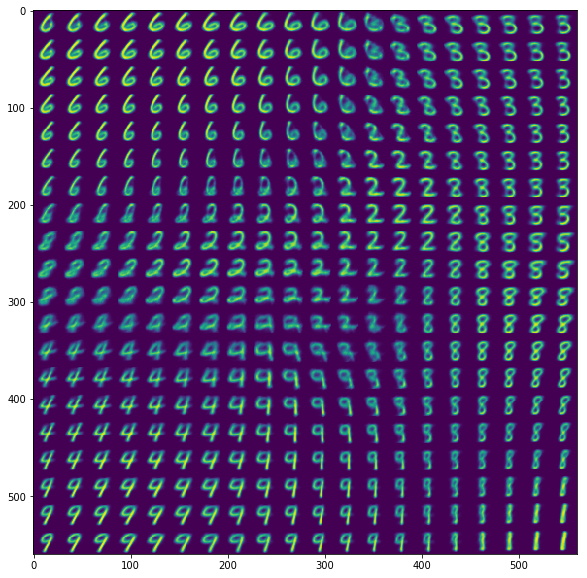

In [14]:
ys,xs = np.mgrid[1:-1:-0.1,-1:1:0.1]
points = np.stack([xs.ravel(),ys.ravel()],axis=-1)

grid_images = sess.run(outputs, 
                       feed_dict={sampled_code:points})

plt.figure(figsize=(10,10))
plt.imshow(grid_images
           .reshape(20,20,28,28)
           .transpose(0,2,1,3)
           .reshape(560,560))
plt.show()

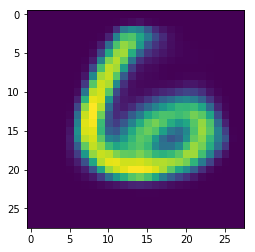

In [15]:
plt.imshow(grid_images.reshape(-1,28,28)[9])

### 참고 자료들
1. [Variational Auto Encoder: Intuition and Implementation](https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/)
2. [알기쉬운 Variational autoencoder](https://www.slideshare.net/ssuser06e0c5/variational-autoencoder-76552518)
3. [Auto Encoder의 모든 것](https://www.slideshare.net/NaverEngineering/ss-96581209)
4. [초짜 대학원생의 입장에서 이해하는 Auto-Encoding Variational Bayes (VAE) (2)](http://jaejunyoo.blogspot.com/2017/04/auto-encoding-variational-bayes-vae-2.html)
5. [A Briefl Introduction to Manifold Learning](https://www.slideshare.net/plutoyang/manifold-learning-64891420)